In [17]:
import shapely
from shapely import speedups
from shapely.geometry import Polygon
from shapely.geometry import MultiPolygon
import math
import statistics
import cv2
import matplotlib.pyplot as plt
import numpy as np
speedups.enable()

In [55]:
def calculate_initial_compass_bearing(pointA, pointB):
    """
    Calculates the bearing between two points.
    The formulae used is the following:
        θ = atan2(sin(Δlong).cos(lat2),
                  cos(lat1).sin(lat2) − sin(lat1).cos(lat2).cos(Δlong))
    :Parameters:
      - `pointA: The tuple representing the latitude/longitude for the
        first point. Latitude and longitude must be in decimal degrees
      - `pointB: The tuple representing the latitude/longitude for the
        second point. Latitude and longitude must be in decimal degrees
    :Returns:
      The bearing in degrees
    :Returns Type:
      float
    """
    if (type(pointA) != tuple) or (type(pointB) != tuple):
        raise TypeError("Only tuples are supported as arguments")

    lat1 = math.radians(pointA[0])
    lat2 = math.radians(pointB[0])

    diffLong = math.radians(pointB[1] - pointA[1])

    x = math.sin(diffLong) * math.cos(lat2)
    y = math.cos(lat1) * math.sin(lat2) - (math.sin(lat1)
            * math.cos(lat2) * math.cos(diffLong))

    initial_bearing = math.atan2(x, y)

    # Now we have the initial bearing but math.atan2 return values
    # from -180° to + 180° which is not what we want for a compass bearing
    # The solution is to normalize the initial bearing as shown below
    initial_bearing = math.degrees(initial_bearing)
    compass_bearing = (initial_bearing + 360) % 360

    return compass_bearing

In [82]:
def calculate_segment_angles(polySimple, maxAngleChange = 45):
    """
    Calculates angles of all polygon segments to cardinal directions.
    :Parameters:
      - `polySimple: shapely polygon object containing simplified building.
      - `maxAngleChange: angle (0,45> degrees. Sets the maximum angle deviation
                         from the cardinal direction for the segment to be still 
                         considered to continue in the same direction as the 
                         previous segment.
    :Returns:
      - orgAngle: Segments bearing
      - corAngle: Segments angles to closest cardinal direction
      - dirAngle: Segments direction [N, E, S, W] as [0, 1, 2, 3]
    :Returns Type:
      list
    """
    # Convert limit angle to angle for subtraction
    maxAngleChange = 45 - maxAngleChange

    # Get points Lat/Lon
    simpleX = polySimple.exterior.xy[0]
    simpleY = polySimple.exterior.xy[1]

    # Calculate angle to cardinal directions for each segment of polygon
    orgAngle = [] # Original angles
    corAngle = [] # Correction angles used for rotation
    dirAngle = [] # 0,1,2,3 = N,E,S,W
    limit = [0] * 4

    for i in range(0, (len(simpleX) - 1)):
        point1 = (simpleY[i], simpleX[i])
        point2 = (simpleY[i+1], simpleX[i+1])
        angle = calculate_initial_compass_bearing(point1, point2)

        if angle > (45 + limit[1]) and angle <= (135 - limit[1]):
            orgAngle.append(angle)
            corAngle.append(angle - 90)
            dirAngle.append(1)

        elif angle > (135 + limit[2]) and angle <= (225 - limit[2]):
            orgAngle.append(angle)
            corAngle.append(angle - 180)
            dirAngle.append(2)

        elif angle > (225 + limit[3]) and angle <= (315 - limit[3]):
            orgAngle.append(angle)
            corAngle.append(angle - 270)
            dirAngle.append(3)

        elif angle > (315 + limit[0]) and angle <= 360:
            orgAngle.append(angle)
            corAngle.append(angle - 360)
            dirAngle.append(0)

        elif angle >= 0 and angle <= (45 - limit[0]):
            orgAngle.append(angle)
            corAngle.append(angle)
            dirAngle.append(0)


        limit = [0] * 4
        limit[ dirAngle[i] ] = maxAngleChange               # Set angle limit for the current direction
        limit[ (dirAngle[i] + 1) % 4 ] = -maxAngleChange    # Extend the angles for the adjacent directions
        limit[ (dirAngle[i] - 1) % 4 ] = -maxAngleChange

    return orgAngle, corAngle, dirAngle

In [83]:
def rotate_polygon(polySimple, angle):
    """
    Rotates polygon around its centroid for given angle.
    :Parameters:
      - `polySimple: shapely polygon object containing simplified building.
      - `angle: angle of rotation in decimal degrees.  
                Positive = counter-clockwise, Negative = clockwise 
    :Returns:
      - bSR: rotated polygon
    :Returns Type:
      shapely Polygon
    """
    # # Create WGS84 referenced GeoSeries
    # bS = gpd.GeoDataFrame({'geometry':[polySimple]})
    # bS.crs = "EPSG:4326"

    # # Temporary reproject to Merkator and rotate by median angle
    # bSR = bS.to_crs('epsg:3857')
    # bSR = bSR.rotate(angle, origin='centroid', use_radians=False) 
    # bSR = bSR.to_crs('epsg:4326')

    # # Extract only shapely polygon object
    # bSR = bSR[0]

    return shapely.affinity.rotate(polySimple, angle, origin="center", use_radians=False)


In [88]:
def orthogonalize_polygon(polygon, maxAngleChange = 15, skewTolerance = 15):
    """
    Master function that makes all angles in polygon outer and inner rings either 90 or 180 degrees.
    Idea adapted from JOSM function orthogonalize
    1) Calculate bearing [0-360 deg] of each polygon segment
    2) From bearing determine general direction [N, E, S ,W], then calculate angle deviation from nearest cardinal direction for each segment
    3) Rotate polygon by median deviation angle to align segments with xy coord axes (cardinal directions)
    4) For vertical segments replace X coordinates of their points with mean value
       For horizontal segments replace Y coordinates of their points with mean value
    5) Rotate back
    :Parameters:
      - `polygon: shapely polygon object containing simplified building.
      - `maxAngleChange: angle (0,45> degrees. Sets the maximum angle deviation
                         from the cardinal direction for the segment to be still 
                         considered to continue in the same direction as the 
                         previous segment.
      - `skewTolerance: angle <0,45> degrees. Sets skew tolerance for segments that 
                        are at 45˚±Tolerance angle from the overal rectangular shape 
                        of the polygon. Usefull when preserving e.g. bay windows on a 
                        house.
    :Returns:
      - polyOrthog: orthogonalized shapely polygon where all angles are 90 or 180 degrees
    :Returns Type:
      shapely Polygon
    """


    # Get angles from cardinal directions of all segments
    orgAngle, corAngle, dirAngle = calculate_segment_angles(polygon)

    # Calculate median angle that will be used for rotation
    if statistics.stdev(corAngle) < 30:
        medAngle = statistics.median(corAngle)
        #avAngle = statistics.mean(corAngle)
    else:
        medAngle = 45  # Account for cases when building is at ~45˚ and we can't decide if to turn clockwise or anti-clockwise
    
    # Rotate polygon to align its edges to cardinal directions
    polySimpleR = rotate_polygon(polygon, medAngle)

    # Get directions of rotated polygon segments
    orgAngle, corAngle, dirAngle = calculate_segment_angles(polySimpleR, maxAngleChange)

    # Get Lat/Lon of rotated polygon points
    rotatedX = polySimpleR.exterior.xy[0].tolist()
    rotatedY = polySimpleR.exterior.xy[1].tolist()

    # Scan backwards to check if starting segment is a continuation of straight region in the same direction
    shift = 0
    for i in range(1, len(dirAngle)):
        if dirAngle[0] == dirAngle[-i]:
            shift = i
        else:
            break
    # If the first segment is part of continuing straight region then reset the index to its beginning
    if shift != 0:
        dirAngle  = dirAngle[-shift:] + dirAngle[:-shift]
        orgAngle  = orgAngle[-shift:] + orgAngle[:-shift]
        rotatedX = rotatedX[-shift-1:-1] + rotatedX[:-shift]    # First and last points are the same in closed polygons
        rotatedY = rotatedY[-shift-1:-1] + rotatedY[:-shift]

    # Fix 180 degree turns (N->S, S->N, E->W, W->E)
    # Subtract two adjacent directions and if the difference is 2, which means we have 180˚ turn (0,1,3 are OK) then use the direction of the previous segment
    dirAngleRoll = dirAngle[1:] + dirAngle[0:1]
    dirAngle = [ dirAngle[i-1] if abs(dirAngle[i]-dirAngleRoll[i])==2 else dirAngle[i] for i in range(len(dirAngle)) ]

    # Cycle through all segments
    # Adjust points coodinates by taking the average of points in segment
    dirAngle.append(dirAngle[0]) # Append dummy value
    orgAngle.append(orgAngle[0]) # Append dummy value
    segmentBuffer = [] # Buffer for determining which segments are part of one large straight line 

    for i in range(0, len(dirAngle) - 1):
        # Preserving skewed walls: Leave walls that are obviously meant to be skewed 45˚+/- tolerance˚ (e.g.angle 30-60 degrees) off main walls as untouched
        if orgAngle[i] % 90 > (45 - skewTolerance) and orgAngle[i] % 90 < (45 + skewTolerance):
            continue

        # Dealing with adjacent segments following the same direction
        segmentBuffer.append(i) 
        if dirAngle[i] == dirAngle[i + 1]: # If next segment is of same orientation, we need 180 deg angle for straight line. Keep checking.
            if orgAngle[i + 1] % 90 > (45 - skewTolerance) and orgAngle[i + 1] % 90 < (45 + skewTolerance):
                pass
            else:
                continue

        if dirAngle[i] in {0, 2}:   # for N,S segments avereage x coordinate
            tempX = statistics.mean( rotatedX[ segmentBuffer[0]:segmentBuffer[-1]+2 ] )
            # Update with new coordinates
            rotatedX[ segmentBuffer[0]:segmentBuffer[-1]+2 ] = [tempX] * (len(segmentBuffer) + 1)  # Segment has 2 points therefore +1
        elif dirAngle[i] in {1, 3}:  # for E,W segments avereage y coordinate 
            tempY = statistics.mean( rotatedY[ segmentBuffer[0]:segmentBuffer[-1]+2 ] )
            # Update with new coordinates
            rotatedY[ segmentBuffer[0]:segmentBuffer[-1]+2 ] = [tempY] * (len(segmentBuffer) + 1)
        
        if 0 in segmentBuffer:  # Copy change in first point to its last point so we don't lose it during Reverse shift
            rotatedX[-1] = rotatedX[0]
            rotatedY[-1] = rotatedY[0]
        
        segmentBuffer = []
    

    # Reverse shift so we get polygon with the same start/end point as before
    if shift != 0:
        rotatedX = rotatedX[shift:] + rotatedX[1:shift+1]    # First and last points are the same in closed polygons
        rotatedY = rotatedY[shift:] + rotatedY[1:shift+1]
    else:
        rotatedX[0] = rotatedX[-1]    # Copy updated coordinates to first node
        rotatedY[0] = rotatedY[-1]

    # Create polygon from new points
    polyNew = Polygon(zip(rotatedX, rotatedY))
    
    # Rotate polygon back
    polyNew = rotate_polygon(polyNew, -medAngle)

    return polyNew


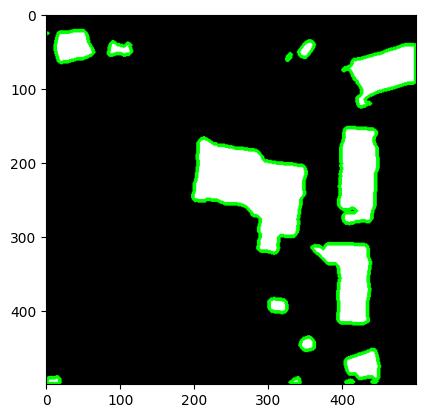

In [105]:
imgs = ["6259_564_1.tif"] 
geometries = []
for img in imgs:
    mask = cv2.imread(f"datatest/{img}", cv2.IMREAD_GRAYSCALE)
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    geometries.append(contours)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

    mask = cv2.drawContours(mask, contours, -1, (0,255, 0), 3)
    plt.imshow(mask)

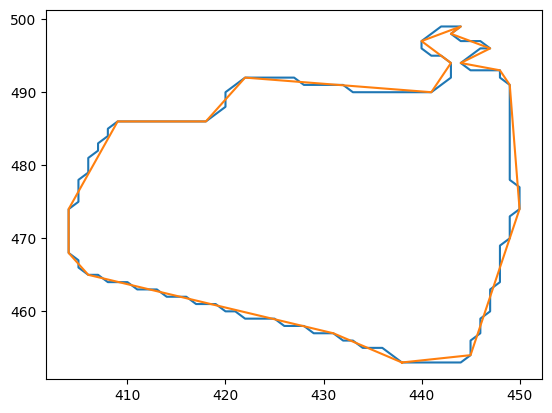

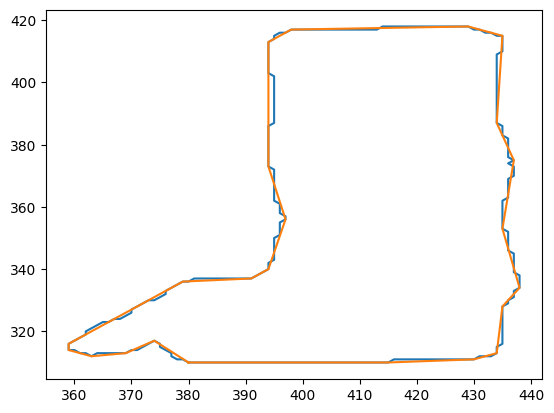

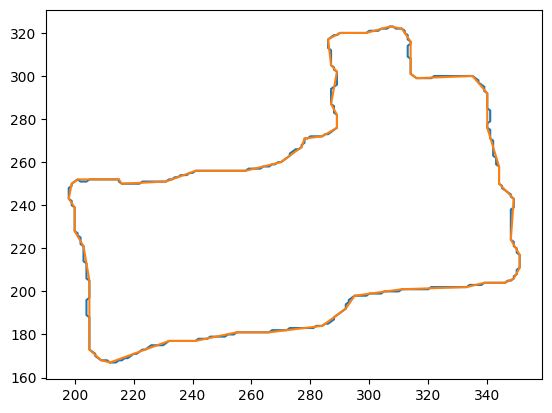

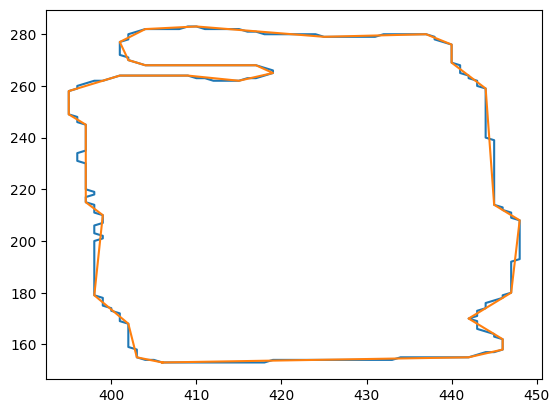

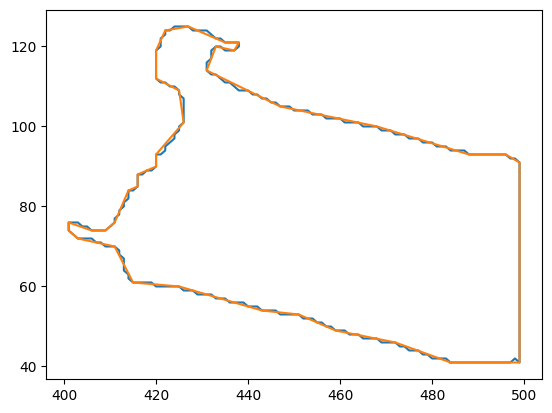

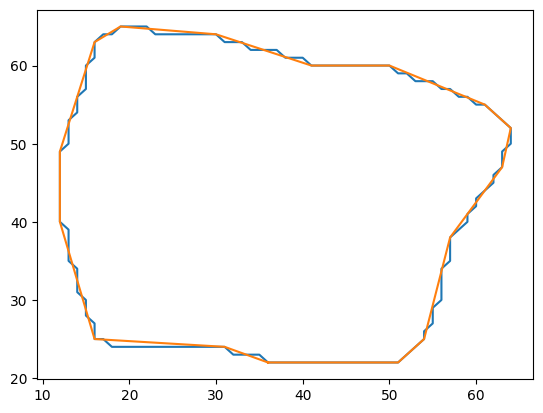

In [113]:
imgs = ["6259_564_1.tif"] 
geometries = []
for img in imgs:
    mask = cv2.imread(f"datatest/{img}", cv2.IMREAD_GRAYSCALE)
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for build in contours:
        if len(build) > 50:
            build = shapely.geometry.polygon.Polygon(np.squeeze(build))
            buildOrtho = orthogonalize_polygon(build)

            plt.plot(*build.exterior.xy)
            # plt.plot(*buildOrtho.exterior.xy)
            plt.plot(*build.simplify(1.0).exterior.xy)
            plt.show()